#### Objective: Predict the premium to be paid by an individual for an health insurance given their details

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import klib

In [2]:
# loading dataset:
data_file = 'insurance_premium.csv'
ip = pd.read_csv(data_file)

In [3]:
ip.shape

(1337, 7)

In [4]:
ip.head()

,age,sex,bmi,children,smoker,region,expenses
0,28,female,25.9,1,no,northwest,4133.64
1,24,female,20.5,0,yes,northeast,14571.89
2,61,male,36.1,3,no,southwest,27941.29
3,21,male,31.1,0,no,southwest,1526.31
4,33,female,33.5,0,yes,southwest,37079.37


Target variable: Expenses

In [5]:
# Using Kblib convert data types to reduce memory
ip = klib.convert_datatypes(ip)
ip.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1337 non-null   int8    
 1   sex       1337 non-null   category
 2   bmi       1337 non-null   float32 
 3   children  1337 non-null   int8    
 4   smoker    1337 non-null   category
 5   region    1337 non-null   category
 6   expenses  1337 non-null   float32 
dtypes: category(3), float32(2), int8(2)
memory usage: 17.9 KB


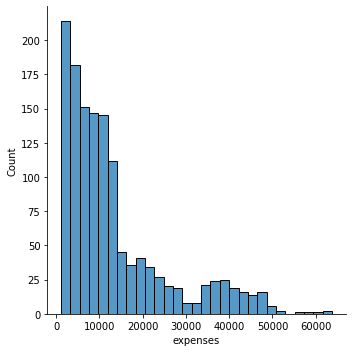

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.displot(ip['expenses'])

The target variable is positvely skewed

In [7]:
from scipy.stats import skew

print('Skewness of target after log tranformation: ', skew(np.log(ip['expenses'])))
print('Skewness of target after square root tranformation: ', skew(np.sqrt(ip['expenses'])))
print('Skewness of target after cube root tranformation: ', skew(np.cbrt(ip['expenses'])))
print('Skewness of target after reciprocal tranformation: ', skew(np.reciprocal(ip['expenses'])))

Skewness of target after log tranformation:  -0.0897386372089386
Skewness of target after square root tranformation:  0.7951013445854187
Skewness of target after cube root tranformation:  0.5149011015892029
Skewness of target after reciprocal tranformation:  1.8808354139328003


Using log tranformation on the target variable to reduce skewness

In [8]:
ip['expenses'] = np.log(ip['expenses'])

In [9]:
ip.head()

,age,sex,bmi,children,smoker,region,expenses
0,28,female,25.900000,1,no,northwest,8.326914
1,24,female,20.500000,0,yes,northeast,9.586849
2,61,male,36.099998,3,no,southwest,10.237861
3,21,male,31.100000,0,no,southwest,7.330608
4,33,female,33.500000,0,yes,southwest,10.520816


##### Spliting dataset into train and test

In [10]:
from sklearn.model_selection import train_test_split

ip_train, ip_test = train_test_split(ip, test_size=0.2, random_state=2)
ip_train.reset_index(drop=True, inplace=True)
ip_test.reset_index(drop=True, inplace=True)

print('Shape of train set : ', ip_train.shape)
print('Shape of test set : ', ip_test.shape)

Shape of train set :  (1069, 7)
Shape of test set :  (268, 7)


##### Feature Engineering

Using dummies to convert categorical variable - sex, smoker and region

In [11]:
# Converting categorical variable in both train and test
for col in ip.select_dtypes('category'):
    temp_train = pd.get_dummies(ip_train[col], drop_first=True, prefix=col)
    ip_train = pd.concat([ip_train, temp_train], 1)
    del ip_train[col]
    
    temp_test = pd.get_dummies(ip_test[col], drop_first=True, prefix=col)
    ip_test = pd.concat([ip_test, temp_test], 1)
    del ip_test[col]

Outlier treatment in varible 'bmi'

In [12]:
# Computing 10th, 90th percentiles and replacing the outliers in train and test datasets

#Train
tenth_percentile = np.percentile(ip_train['bmi'], 10)
ninetieth_percentile = np.percentile(ip_train['bmi'], 90)
#print(tenth_percentile, ',', ninetieth_percentile)
ip_train['bmi'] = np.where(ip_train['bmi']<tenth_percentile, tenth_percentile, ip_train['bmi'])
ip_train['bmi'] = np.where(ip_train['bmi']>ninetieth_percentile, ninetieth_percentile, ip_train['bmi'])

#Test
tenth_percentile = np.percentile(ip_test['bmi'], 10)
ninetieth_percentile = np.percentile(ip_test['bmi'], 90)
#print(tenth_percentile, ',', ninetieth_percentile)
ip_test['bmi'] = np.where(ip_test['bmi']<tenth_percentile, tenth_percentile, ip_test['bmi'])
ip_test['bmi'] = np.where(ip_test['bmi']>ninetieth_percentile, ninetieth_percentile, ip_test['bmi'])

##### Spliting into features and target

In [13]:
x_train = ip_train.drop('expenses', axis=1)
y_train = ip_train['expenses']

x_test = ip_test.drop('expenses', axis=1)
y_test = ip_test['expenses']

##### Training Models

In [14]:
# loading necessary libraries

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [15]:
models = [LinearRegression(), Ridge(), Lasso(), DecisionTreeRegressor(), BaggingRegressor(), RandomForestRegressor(), 
          ExtraTreesRegressor(), AdaBoostRegressor(), GradientBoostingRegressor(), XGBRegressor(), KNeighborsRegressor()]

names = ['Linear Regression', 'Ridge', 'Lasso', 'DT', 'Bagging', 'RF', 'ExtraTrees', 'AdaBoost', 'GradientBoost', 
         'XGB', 'KNN']

In [16]:
train_score = []
test_score = []

for model, name in zip(models, names):
    print(name)
    model.fit(x_train, y_train)
    score_train = np.sqrt(mean_squared_error(y_train, model.predict(x_train)))
    train_score.append(score_train)
    score_test = np.sqrt(mean_squared_error(y_test, model.predict(x_test)))
    test_score.append(score_test)

Linear Regression
Ridge
Lasso
DT
Bagging
RF
ExtraTrees
AdaBoost
GradientBoost
XGB
KNN


In [17]:
cross_validation_score = []

for model, name in zip(models, names):
    print(name)
    score = cross_val_score(model, x_train, y_train, scoring='neg_root_mean_squared_error', cv=10).mean()
    cross_validation_score.append(score)

Linear Regression
Ridge
Lasso
DT
Bagging
RF
ExtraTrees
AdaBoost
GradientBoost
XGB
KNN


In [18]:
scores_df = pd.DataFrame(list(zip(names, train_score, test_score, cross_validation_score)), 
                         columns=['names', 'train_score', 'test_score', 'cross_validation_score'])
scores_df

,names,train_score,test_score,cross_validation_score
0,Linear Regression,0.445690,0.431267,-0.445232
1,Ridge,0.445705,0.431664,-0.445240
2,Lasso,0.777670,0.799283,-0.776549
3,DT,0.012602,0.553040,-0.512347
4,Bagging,0.165245,0.447649,-0.403804
5,RF,0.144685,0.437224,-0.386057
6,ExtraTrees,0.012602,0.502388,-0.393976
7,AdaBoost,0.464388,0.491433,-0.480465
8,GradientBoost,0.314275,0.376970,-0.363973
9,XGB,0.060294,0.472379,-0.420194


Linear regression, Ridge, Lasso, KNN, AdaBoost models have high bias. DT and XGB models are higly overfitting models for the given data. Bagging and RF models are also overfitting but hypertunning them might improve scores. Gradient Boosting model seems to have low variance and low bias.

##### Hyper tunning Gradient Boosting, Bagging and RF models

###Gradient Boosting Model

There 2 types of parameters here-----

Boosting specific paramters : n_estimators, learning_rate

Tree-specific parameters: min_samples_split, max_depth, min_samples_leaf, max_features

In [19]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

Using Randomized searchCV to search through all the parameters:

In [20]:
grid_params_gbm  = {'n_estimators' : [100, 200, 500, 700, 1000, 1200],
                    'learning_rate' : [0.15,0.1,0.05,0.01,0.005,0.001],
                    'max_features':[2,3,4,5],
                    'max_depth':[2,3,4,5,6,7],
                    'min_samples_split':[2,5,10,20,40,50,80], 
                    'min_samples_leaf':[1,3,5,7,9]
                }

random_search = RandomizedSearchCV(GradientBoostingRegressor(), param_distributions=grid_params_gbm,
                                   cv=10, scoring='neg_root_mean_squared_error', random_state=2, return_train_score=True)
random_search.fit(x_train,y_train)

RandomizedSearchCV(cv=10, estimator=GradientBoostingRegressor(),
                   param_distributions={'learning_rate': [0.15, 0.1, 0.05, 0.01,
                                                          0.005, 0.001],
                                        'max_depth': [2, 3, 4, 5, 6, 7],
                                        'max_features': [2, 3, 4, 5],
                                        'min_samples_leaf': [1, 3, 5, 7, 9],
                                        'min_samples_split': [2, 5, 10, 20, 40,
                                                              50, 80],
                                        'n_estimators': [100, 200, 500, 700,
                                                         1000, 1200]},
                   random_state=2, return_train_score=True,
                   scoring='neg_root_mean_squared_error')

In [21]:
random_search.best_params_, random_search.best_score_, random_search.best_estimator_

({'learning_rate': 0.05,
  'max_depth': 3,
  'max_features': 4,
  'min_samples_leaf': 9,
  'min_samples_split': 20,
  'n_estimators': 200},
 -0.3634967849491401,
 GradientBoostingRegressor(learning_rate=0.05, max_features=4,
                           min_samples_leaf=9, min_samples_split=20,
                           n_estimators=200))

In [22]:
pd.DataFrame(random_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_learning_rate,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.748566,0.065321,0.009376,0.007656,500,50,9,2,6,0.005,...,-0.358978,-0.353903,-0.354952,-0.357552,-0.345542,-0.363297,-0.349089,-0.362766,-0.355454,0.006592
1,0.270326,0.041958,0.003126,0.006251,200,10,3,2,5,0.15,...,-0.178214,-0.170692,-0.172142,-0.166349,-0.160726,-0.175556,-0.171668,-0.176008,-0.172007,0.006417
2,0.325279,0.047934,0.007251,0.007423,200,2,7,5,3,0.1,...,-0.300654,-0.293152,-0.294458,-0.298033,-0.280316,-0.302506,-0.284850,-0.302566,-0.294853,0.007871
3,0.564092,0.086565,0.010938,0.007161,500,80,1,2,4,0.05,...,-0.278577,-0.274139,-0.273611,-0.277279,-0.262583,-0.285191,-0.267625,-0.283010,-0.275080,0.007557
4,1.629690,0.189466,0.014594,0.005402,1000,80,9,3,6,0.01,...,-0.290502,-0.282710,-0.281974,-0.285072,-0.270960,-0.291715,-0.275417,-0.290183,-0.283915,0.007874
5,0.304903,0.045532,0.008506,0.001205,200,5,3,3,3,0.15,...,-0.293002,-0.278895,-0.279334,-0.283753,-0.269702,-0.288081,-0.271657,-0.286071,-0.282033,0.007709
6,0.893527,0.146044,0.011731,0.004855,500,80,9,3,7,0.05,...,-0.227808,-0.221999,-0.218762,-0.222646,-0.208527,-0.227935,-0.217919,-0.226191,-0.221601,0.006823
7,0.373148,0.087374,0.010407,0.003723,200,20,9,4,3,0.05,...,-0.333255,-0.326806,-0.324188,-0.329544,-0.313863,-0.334022,-0.317192,-0.335592,-0.327104,0.007842
8,1.031640,0.082069,0.009876,0.002967,1000,40,7,2,3,0.005,...,-0.369720,-0.363211,-0.364743,-0.365896,-0.352598,-0.374305,-0.358744,-0.375745,-0.365600,0.007338
9,0.188626,0.016432,0.005303,0.000640,200,10,1,4,2,0.15,...,-0.343610,-0.333601,-0.330369,-0.332535,-0.320446,-0.342753,-0.325078,-0.343965,-0.333468,0.008390


In [23]:
gbm_model_random_search = GradientBoostingRegressor(learning_rate=0.05, max_features=4,
                           min_samples_leaf=9, min_samples_split=20,
                           n_estimators=200, random_state=2)
gbm_model_random_search.fit(x_train, y_train)
print('Train score of GBM tunned model uisng RandomizedSearchCV : ', np.sqrt(mean_squared_error(y_train, gbm_model_random_search.predict(x_train))))
print('Test score of GBM tunned model uisng RandomizedSearchCV : ', np.sqrt(mean_squared_error(y_test, gbm_model_random_search.predict(x_test))))

Train score of GBM tunned model uisng RandomizedSearchCV :  0.3306187667720867
Test score of GBM tunned model uisng RandomizedSearchCV :  0.3648439575485909


Using Grid Search CV:

Tunning n_estimators and learning_rate keeping the default tree specific parameters fixed

In [24]:
grid_params_gbm  = {'n_estimators' : [100, 200, 500, 700, 1000, 1200],
                    'learning_rate' : [0.15,0.1,0.05,0.01,0.005,0.001]    
                }

grid_search = GridSearchCV(GradientBoostingRegressor(), 
                           cv=10,
                           param_grid=grid_params_gbm,
                           scoring='neg_root_mean_squared_error')

grid_search.fit(x_train,y_train)

GridSearchCV(cv=10, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.15, 0.1, 0.05, 0.01, 0.005, 0.001],
                         'n_estimators': [100, 200, 500, 700, 1000, 1200]},
             scoring='neg_root_mean_squared_error')

In [25]:
grid_search.best_params_, grid_search.best_score_, grid_search.best_estimator_

({'learning_rate': 0.01, 'n_estimators': 700},
 -0.3591181720197031,
 GradientBoostingRegressor(learning_rate=0.01, n_estimators=700))

Tunning min_samples_split, max_depth, min_samples_leaf, max_features keeping the n_estimators and learning_rate obtained from above fixed

In [28]:
grid_params_gbm  = {'max_features':[2,3,4]
                }

grid_search = GridSearchCV(GradientBoostingRegressor(learning_rate=0.01, n_estimators=700), 
                           cv=10,
                           param_grid=grid_params_gbm,
                           scoring='neg_root_mean_squared_error')

grid_search.fit(x_train,y_train)

GridSearchCV(cv=10,
             estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                 n_estimators=700),
             param_grid={'max_features': [2, 3, 4]},
             scoring='neg_root_mean_squared_error')

In [29]:
grid_search.best_params_, grid_search.best_score_, grid_search.best_estimator_

({'max_features': 4},
 -0.35843137021066934,
 GradientBoostingRegressor(learning_rate=0.01, max_features=4, n_estimators=700))

In [30]:
grid_params_gbm  = {'max_depth':[2,3,4,5,6,7],
                    'min_samples_split':[2,5,10,20,40,50,80], 
                    'min_samples_leaf':[1,3,5,7,9]
                }

grid_search = GridSearchCV(GradientBoostingRegressor(learning_rate=0.01, n_estimators=700, max_features=5), 
                           cv=10,
                           param_grid=grid_params_gbm,
                           scoring='neg_root_mean_squared_error')

grid_search.fit(x_train,y_train)

GridSearchCV(cv=10,
             estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                 max_features=5,
                                                 n_estimators=700),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7],
                         'min_samples_leaf': [1, 3, 5, 7, 9],
                         'min_samples_split': [2, 5, 10, 20, 40, 50, 80]},
             scoring='neg_root_mean_squared_error')

In [31]:
grid_search.best_params_, grid_search.best_score_, grid_search.best_estimator_

({'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 5},
 -0.35903811308798683,
 GradientBoostingRegressor(learning_rate=0.01, max_features=5,
                           min_samples_leaf=3, min_samples_split=5,
                           n_estimators=700))

In [32]:
gbm_model_grid_search = GradientBoostingRegressor(learning_rate=0.01, max_features=4, n_estimators=700, 
                                                  max_depth=3, min_samples_leaf=3, min_samples_split=5, random_state=2)
gbm_model_grid_search.fit(x_train, y_train)
print('Train score of GBM tunned model uisng GridSearchCV : ', np.sqrt(mean_squared_error(y_train, gbm_model_grid_search.predict(x_train))))
print('Test score of GBM tunned model uisng GridSearchCV : ', np.sqrt(mean_squared_error(y_test, gbm_model_grid_search.predict(x_test))))

Train score of GBM tunned model uisng GridSearchCV :  0.3354904241281576
Test score of GBM tunned model uisng GridSearchCV :  0.36471931086375636


###Bagging Model

There 2 types of parameters here-----

Bagged model specific paramters : base_estimator, n_estimators, max_samples

Base estimator specific parameters: max_features

Kepping the base_estimator as Decision Tree fixed as linear model or KNN model doesnot seem to give good result

Using Randomized searchCV to search through n_estimators, max_samples and max_features:

In [33]:
params_bagged  = {'n_estimators' : [100, 200, 350, 500, 700, 850, 1000],
                  'max_samples' : [0.05, 0.1, 0.2, 0.3, 0.5, 0.8],
                  'max_features' : [2,3,4]
                }
random_search = RandomizedSearchCV(BaggingRegressor(), param_distributions=params_bagged,
                                   cv=10, scoring='neg_root_mean_squared_error', random_state=2, return_train_score=True)
random_search.fit(x_train,y_train)

RandomizedSearchCV(cv=10, estimator=BaggingRegressor(),
                   param_distributions={'max_features': [2, 3, 4],
                                        'max_samples': [0.05, 0.1, 0.2, 0.3,
                                                        0.5, 0.8],
                                        'n_estimators': [100, 200, 350, 500,
                                                         700, 850, 1000]},
                   random_state=2, return_train_score=True,
                   scoring='neg_root_mean_squared_error')

In [34]:
random_search.best_params_, random_search.best_score_, random_search.best_estimator_

({'max_features': 4, 'max_samples': 0.3, 'n_estimators': 1000},
 -0.5793120587431801,
 BaggingRegressor(max_features=4, max_samples=0.3, n_estimators=1000))

In [39]:
bagged_random_search = BaggingRegressor(max_features=4, n_estimators=1000, max_samples=0.3, random_state=2)
bagged_random_search.fit(x_train, y_train)
print('Train score of bagged model uisng RandomizedSearchCV : ', np.sqrt(mean_squared_error(y_train, bagged_random_search.predict(x_train))))
print('Test score of bagged model uisng RandomizedSearchCV : ', np.sqrt(mean_squared_error(y_test, bagged_random_search.predict(x_test))))

Train score of bagged model uisng RandomizedSearchCV :  0.49237916342899496
Test score of bagged model uisng RandomizedSearchCV :  0.5700836683104283


Using Grid searchCV to search through n_estimators, max_samples and max_features:

In [36]:
params_bagged  = {'n_estimators' : [100, 200, 350, 500, 700, 850, 1000],
                  'max_samples' : [0.05, 0.1, 0.2, 0.3, 0.5, 0.8],
                  'max_features' : [2,3,4]
                }
grid_search = GridSearchCV(BaggingRegressor(), 
                           cv=10,
                           param_grid=params_bagged,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(x_train,y_train)

GridSearchCV(cv=10, estimator=BaggingRegressor(),
             param_grid={'max_features': [2, 3, 4],
                         'max_samples': [0.05, 0.1, 0.2, 0.3, 0.5, 0.8],
                         'n_estimators': [100, 200, 350, 500, 700, 850, 1000]},
             scoring='neg_root_mean_squared_error')

In [37]:
grid_search.best_params_, grid_search.best_score_, grid_search.best_estimator_

({'max_features': 4, 'max_samples': 0.5, 'n_estimators': 200},
 -0.5689610943037595,
 BaggingRegressor(max_features=4, max_samples=0.5, n_estimators=200))

In [38]:
bagged_grid_search = BaggingRegressor(max_features=4, n_estimators=200, max_samples=0.5, random_state=2)
bagged_grid_search.fit(x_train, y_train)
print('Train score of bagged model using GridSearchCV : ', np.sqrt(mean_squared_error(y_train, bagged_grid_search.predict(x_train))))
print('Test score of bagged model using GridSearchCV : ', np.sqrt(mean_squared_error(y_test, bagged_grid_search.predict(x_test))))

Train score of bagged model using GridSearchCV :  0.4505025237060744
Test score of bagged model using GridSearchCV :  0.5689732133225062


####Random Forest Model

Parameters to tune for Random forest model : n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features, min_impurity_decrease, max_samples

Using Randomized SearchCV to search through all the values for the parameters:

In [42]:
params_rf = {'n_estimators' : [100, 200, 350, 500, 700, 850, 1000],
             'max_depth' : [3,4,5,6,7,8],
             'max_features' : [2,3,4],
             'max_samples' : [0.01, 0.1, 0.2, 0.4, 0.5, 0.8]    
            }

random_search = RandomizedSearchCV(RandomForestRegressor(), param_distributions=params_rf,
                                   cv=10, scoring='neg_root_mean_squared_error', random_state=2, return_train_score=True)
random_search.fit(x_train,y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': [3, 4, 5, 6, 7, 8],
                                        'max_features': [2, 3, 4],
                                        'max_samples': [0.01, 0.1, 0.2, 0.4,
                                                        0.5, 0.8],
                                        'n_estimators': [100, 200, 350, 500,
                                                         700, 850, 1000]},
                   random_state=2, return_train_score=True,
                   scoring='neg_root_mean_squared_error')

In [43]:
random_search.best_params_, random_search.best_score_, random_search.best_estimator_

({'max_depth': 6, 'max_features': 4, 'max_samples': 0.8, 'n_estimators': 850},
 -0.36699884224274626,
 RandomForestRegressor(max_depth=6, max_features=4, max_samples=0.8,
                       n_estimators=850))

In [45]:
rf_random_search = RandomForestRegressor(n_estimators=850, max_depth=6, max_features=4, max_samples=0.8, random_state=2)
rf_random_search.fit(x_train, y_train)
print('Train score of rf model uisng RandomizedSearchCV : ', np.sqrt(mean_squared_error(y_train, rf_random_search.predict(x_train))))
print('Test score of rf model uisng RandomizedSearchCV : ', np.sqrt(mean_squared_error(y_test, rf_random_search.predict(x_test))))

Train score of rf model uisng RandomizedSearchCV :  0.3281507829003378
Test score of rf model uisng RandomizedSearchCV :  0.37378294420611907


Using Grid Search CV

Tuning n_estimators keeping tree specific default parameters fixed:

In [46]:
params_rf = {'n_estimators' : [100, 200, 350, 500, 700, 850, 1000]}

grid_search = GridSearchCV(RandomForestRegressor(), 
                           cv=10,
                           param_grid=params_rf,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(x_train,y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [100, 200, 350, 500, 700, 850, 1000]},
             scoring='neg_root_mean_squared_error')

In [47]:
grid_search.best_params_, grid_search.best_score_, grid_search.best_estimator_

({'n_estimators': 500},
 -0.3833848669376855,
 RandomForestRegressor(n_estimators=500))

In [48]:
params_rf = {'max_depth' : [3,4,5,6,7,8],
             'max_features' : [2,3,4],
             'max_samples' : [0.01, 0.1, 0.2, 0.4, 0.5, 0.8] 
    }

grid_search = GridSearchCV(RandomForestRegressor(n_estimators=500), 
                           cv=10,
                           param_grid=params_rf,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(x_train,y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(n_estimators=500),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8],
                         'max_features': [2, 3, 4],
                         'max_samples': [0.01, 0.1, 0.2, 0.4, 0.5, 0.8]},
             scoring='neg_root_mean_squared_error')

In [49]:
grid_search.best_params_, grid_search.best_score_, grid_search.best_estimator_

({'max_depth': 7, 'max_features': 4, 'max_samples': 0.8},
 -0.3627449641301904,
 RandomForestRegressor(max_depth=7, max_features=4, max_samples=0.8,
                       n_estimators=500))

In [50]:
rf_grid_search = RandomForestRegressor(n_estimators=500, max_depth=7, max_features=4, max_samples=0.8, random_state=2)
rf_grid_search.fit(x_train, y_train)
print('Train score of rf model uisng GridSearchCV : ', np.sqrt(mean_squared_error(y_train, rf_grid_search.predict(x_train))))
print('Test score of rf model uisng GridSearchCV : ', np.sqrt(mean_squared_error(y_test, rf_grid_search.predict(x_test))))

Train score of rf model uisng GridSearchCV :  0.2978143594066878
Test score of rf model uisng GridSearchCV :  0.3799528635423457


Final model : GBM model after tuning using GridSearchCV

In [51]:
insurance_premium_pred_model = GradientBoostingRegressor(learning_rate=0.01, max_features=4, n_estimators=700, 
                                                  max_depth=3, min_samples_leaf=3, min_samples_split=5, random_state=2)
insurance_premium_pred_model.fit(x_train,y_train)

GradientBoostingRegressor(learning_rate=0.01, max_features=4,
                          min_samples_leaf=3, min_samples_split=5,
                          n_estimators=700, random_state=2)